In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split

# Model Reduction

## Loading data

In [33]:
pish_df = pd.read_csv("pishing.csv")

## Splitting data

In [34]:
#creating backup
df = pish_df.copy()

# Prepare features and target
X = pish_df.drop(columns=['result'])
y = pish_df['result']

# Convert target to binary (0 and 1) - assuming -1 is legitimate, 1 is phishing
y_binary = (y == 1).astype(int)

# Split the data (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Phishing rate in train: {y_train.mean():.2%}")
print(f"Phishing rate in test: {y_test.mean():.2%}")

Training set size: 8844
Test set size: 2211
Phishing rate in train: 55.70%
Phishing rate in test: 55.68%


## Fit the model using a GLM with a Binomial Familiy

In [35]:
X_train_const = sm.add_constant(X_train)

model = sm.GLM(
    y_train, 
    X_train_const, 
    family=sm.families.Binomial()
)
result = model.fit()

## Create a DataFrame with the model statistics: Deviance, Null Deviance, Deviance Explained, Log_likelihood, AIC

In [36]:
# Extract statistics
deviance = result.deviance
null_deviance = result.null_deviance
loglik = result.llf
aic = result.aic

# Deviance Explained = 1 - (Residual Deviance / Null Deviance)
deviance_explained = 1 - (deviance / null_deviance)

# Create DataFrame
model_stats = pd.DataFrame({
    "Deviance": [deviance],
    "Null Deviance": [null_deviance],
    "Deviance Explained": [deviance_explained],
    "Log_Likelihood": [loglik],
    "AIC": [aic]
})

model_stats


,Deviance,Null Deviance,Deviance Explained,Log_Likelihood,AIC
0,3208.443118,12145.249907,0.735827,-1604.221559,3270.443118


## Run the Predictions and createa DataFrame with the following Columns: "Actual", "Predicted Probabilty", "Predicted Class", "Correct(True or False)"

In [37]:


# Add constant to X_test (wie beim Training)
X_test_const = sm.add_constant(X_test)

# --- 1. Predicted Probabilities ---
pred_prob = result.predict(X_test_const)

# --- 2. Predicted Class (Threshold = 0.5) ---
pred_class = (pred_prob >= 0.5).astype(int)

# --- 3. Create DataFrame ---
pred_df = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted Probability": pred_prob,
    "Predicted Class": pred_class,
    "Correct (True/False)": (pred_class == y_test.values)
})

pred_df.head()


,Actual,Predicted Probability,Predicted Class,Correct (True/False)
6461,0,0.003812,0,True
10463,0,0.170763,0,True
3390,1,1.000000,1,True
4424,0,0.013243,0,True
6256,0,0.030835,0,True


## Get the metrics from Scikit learn and create a DataFrame with Accuracy, Precision, Recall, F1-Score, ROC-AUC

In [38]:
# 11. Calculating model performance metrics 
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Compute metrics
accuracy = accuracy_score(y_test, pred_class)
precision = precision_score(y_test, pred_class)
recall = recall_score(y_test, pred_class)
f1 = f1_score(y_test, pred_class)
roc_auc = roc_auc_score(y_test, pred_prob)

# Create DataFrame
metrics_df = pd.DataFrame({
    "Accuracy": [accuracy],
    "Precision": [precision],
    "Recall": [recall],
    "F1-Score": [f1],
    "ROC-AUC": [roc_auc]
})

metrics_df


,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,0.928539,0.923441,0.950447,0.936749,0.980805


## Get the confusion matrix as a Dataframe

In [39]:
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_test, pred_class)

# Create DataFrame with labels
cm_df = pd.DataFrame(
    cm,
    index=["Actual: 0 (Legit)", "Actual: 1 (Phishing)"],
    columns=["Predicted: 0 (Legit)", "Predicted: 1 (Phishing)"]
)

cm_df



,Predicted: 0 (Legit),Predicted: 1 (Phishing)
Actual: 0 (Legit),883,97
Actual: 1 (Phishing),61,1170


## Calculate the Correlation Matrix


In [40]:
# Calculate correlation matrix for the feature set
corr_matrix = X_train.corr()

corr_matrix



,having_ip_address,url_length,shortining_service,having_at_symbol,double_slash_redirecting,prefix_suffix,having_sub_domain,sslfinal_state,domain_registration_length,favicon,...,rightclick,popupwindow,iframe,age_of_domain,dnsrecord,web_traffic,page_rank,google_index,links_pointing_to_page,statistical_report
having_ip_address,1.000000,-0.051077,0.401872,0.162499,0.395360,-0.006558,-0.076443,0.072897,-0.019997,0.091352,...,0.047433,0.103751,0.057581,-0.008775,-0.054175,-0.001891,-0.088994,0.029677,-0.342114,-0.022332
url_length,-0.051077,1.000000,-0.093966,-0.073187,-0.082995,0.057891,-0.002526,0.044448,-0.222472,-0.042867,...,-0.018013,-0.049038,-0.010434,0.181996,-0.039511,0.007017,0.190677,0.003724,-0.025371,-0.070444
shortining_service,0.401872,-0.093966,1.000000,0.106489,0.837315,-0.088009,-0.038875,-0.058386,0.066451,0.012527,...,0.042869,0.041667,0.023248,-0.042972,0.433871,-0.046537,0.010026,0.156580,-0.195812,0.087821
having_at_symbol,0.162499,-0.073187,0.106489,1.000000,0.090718,-0.015336,-0.051693,0.032536,0.019599,0.307332,...,0.216971,0.294273,0.286417,-0.002797,-0.044199,0.029194,-0.063392,0.043546,-0.004947,-0.080060
double_slash_redirecting,0.395360,-0.082995,0.837315,0.090718,1.000000,-0.087171,-0.039180,-0.027361,0.054191,0.041531,...,0.025452,0.060093,0.014704,-0.041553,0.425652,-0.061324,-0.008365,0.179379,-0.188288,0.069596
prefix_suffix,-0.006558,0.057891,-0.088009,-0.015336,-0.087171,1.000000,0.087704,0.262162,-0.096645,-0.006067,...,-0.022528,-0.011107,-0.034930,0.070270,-0.015874,0.113466,-0.004141,0.063387,0.057588,-0.000590
having_sub_domain,-0.076443,-0.002526,-0.038875,-0.051693,-0.039180,0.087704,1.000000,0.271224,-0.073150,-0.013037,...,0.023232,-0.021542,0.017327,0.125148,0.126978,-0.012635,0.124969,0.054573,-0.013883,0.077674
sslfinal_state,0.072897,0.044448,-0.058386,0.032536,-0.027361,0.262162,0.271224,1.000000,-0.188853,-0.008927,...,0.019961,-0.006024,-0.000799,0.162674,0.058368,0.263084,0.077444,0.089593,-0.020356,0.069250
domain_registration_length,-0.019997,-0.222472,0.066451,0.019599,0.054191,-0.096645,-0.073150,-0.188853,1.000000,0.049801,...,0.017771,0.045387,-0.004625,-0.068500,-0.012083,-0.128314,-0.066741,-0.041583,0.128929,-0.003725
favicon,0.091352,-0.042867,0.012527,0.307332,0.041531,-0.006067,-0.013037,-0.008927,0.049801,1.000000,...,0.427044,0.940359,0.632327,0.006545,0.087544,-0.047884,0.013747,-0.015080,-0.127053,0.301057


In [41]:
corr_matrix = df.corr()

corr_matrix


,having_ip_address,url_length,shortining_service,having_at_symbol,double_slash_redirecting,prefix_suffix,having_sub_domain,sslfinal_state,domain_registration_length,favicon,...,popupwindow,iframe,age_of_domain,dnsrecord,web_traffic,page_rank,google_index,links_pointing_to_page,statistical_report,result
having_ip_address,1.000000,-0.052411,0.403461,0.158699,0.397389,-0.005257,-0.080745,0.071414,-0.022739,0.087025,...,0.096882,0.054694,-0.010446,-0.050733,0.002922,-0.091774,0.029153,-0.339065,-0.019103,0.094160
url_length,-0.052411,1.000000,-0.097881,-0.075108,-0.081247,0.055247,0.003997,0.048754,-0.221892,-0.042497,...,-0.049381,-0.013838,0.179426,-0.040823,0.008993,0.183518,0.002902,-0.022987,-0.067153,0.057430
shortining_service,0.403461,-0.097881,1.000000,0.104447,0.842796,-0.080471,-0.041916,-0.061426,0.060923,0.006101,...,0.036616,0.016581,-0.052596,0.436064,-0.047074,0.014591,0.155844,-0.198410,0.085461,-0.067966
having_at_symbol,0.158699,-0.075108,0.104447,1.000000,0.086960,-0.011726,-0.058976,0.031220,0.015522,0.304899,...,0.290893,0.284410,-0.005499,-0.047872,0.032918,-0.064735,0.037061,-0.006080,-0.080357,0.052948
double_slash_redirecting,0.397389,-0.081247,0.842796,0.086960,1.000000,-0.085590,-0.043079,-0.036200,0.047464,0.035100,...,0.054463,0.010459,-0.050107,0.431409,-0.062369,-0.003132,0.178415,-0.194165,0.070390,-0.038608
prefix_suffix,-0.005257,0.055247,-0.080471,-0.011726,-0.085590,1.000000,0.087891,0.261391,-0.096799,-0.007504,...,-0.014733,-0.036904,0.074116,-0.016556,0.110598,-0.006834,0.067781,0.067423,-0.002763,0.348606
having_sub_domain,-0.080745,0.003997,-0.041916,-0.058976,-0.043079,0.087891,1.000000,0.267649,-0.082839,-0.016704,...,-0.025312,0.010637,0.119254,0.125493,-0.005764,0.120730,0.057673,-0.010526,0.081627,0.298323
sslfinal_state,0.071414,0.048754,-0.061426,0.031220,-0.036200,0.261391,0.267649,1.000000,-0.193622,-0.014757,...,-0.013005,-0.002773,0.162809,0.050972,0.258768,0.074545,0.096051,-0.011710,0.063411,0.714741
domain_registration_length,-0.022739,-0.221892,0.060923,0.015522,0.047464,-0.096799,-0.082839,-0.193622,1.000000,0.054253,...,0.051410,0.004393,-0.062851,-0.010477,-0.134454,-0.059898,-0.039766,0.122672,-0.002212,-0.225789
favicon,0.087025,-0.042497,0.006101,0.304899,0.035100,-0.007504,-0.016704,-0.014757,0.054253,1.000000,...,0.939633,0.627607,-0.002628,0.088211,-0.050922,0.011699,-0.016668,-0.127243,0.300917,-0.000280


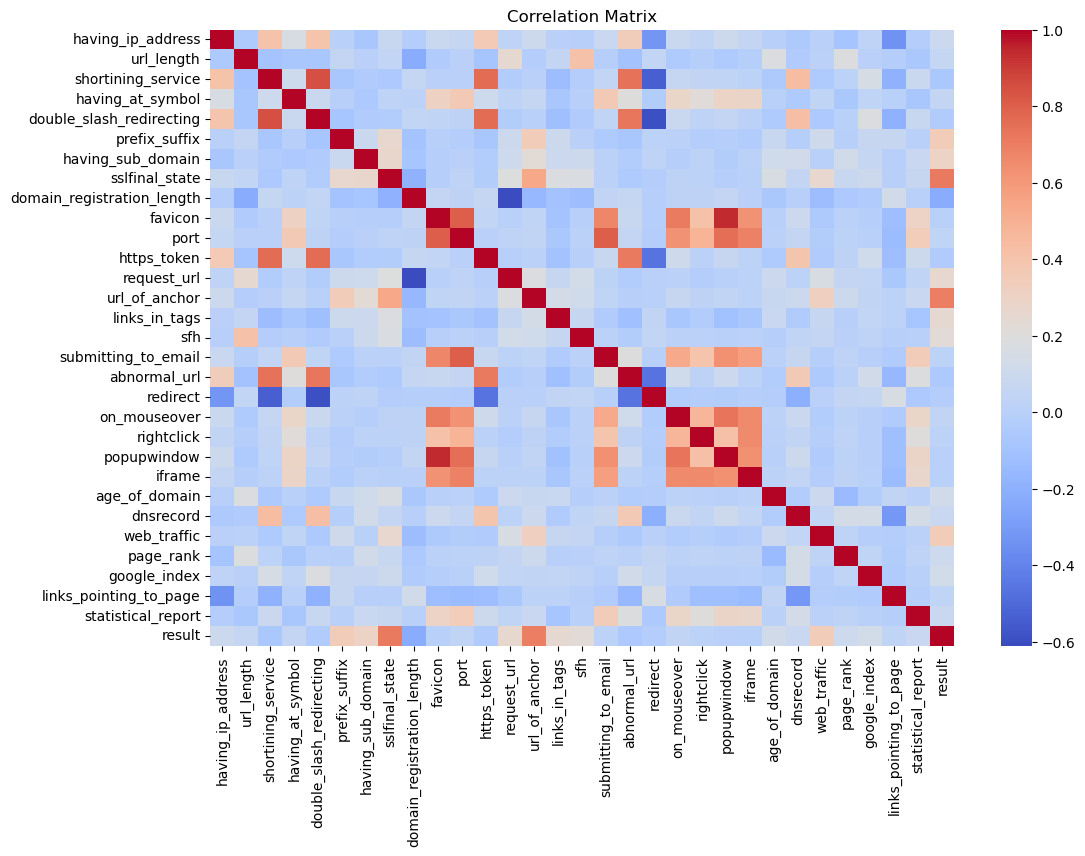

In [42]:


plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


## Calculate the Variance Inflation Factor

In [46]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Add constant to feature matrix (required for VIF calculation)
X_train_const = sm.add_constant(X_train)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_train_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_const.values, i)
                   for i in range(X_train_const.shape[1])]

vif_data



,Feature,VIF
0,const,14.521723
1,having_ip_address,1.727002
2,url_length,1.518029
3,shortining_service,4.464538
4,having_at_symbol,1.416845
5,double_slash_redirecting,4.643828
6,prefix_suffix,1.193850
7,having_sub_domain,1.188494
8,sslfinal_state,1.618344
9,domain_registration_length,1.659267


## Create a Feature Clustering Dendogram, based on the correlation matrix

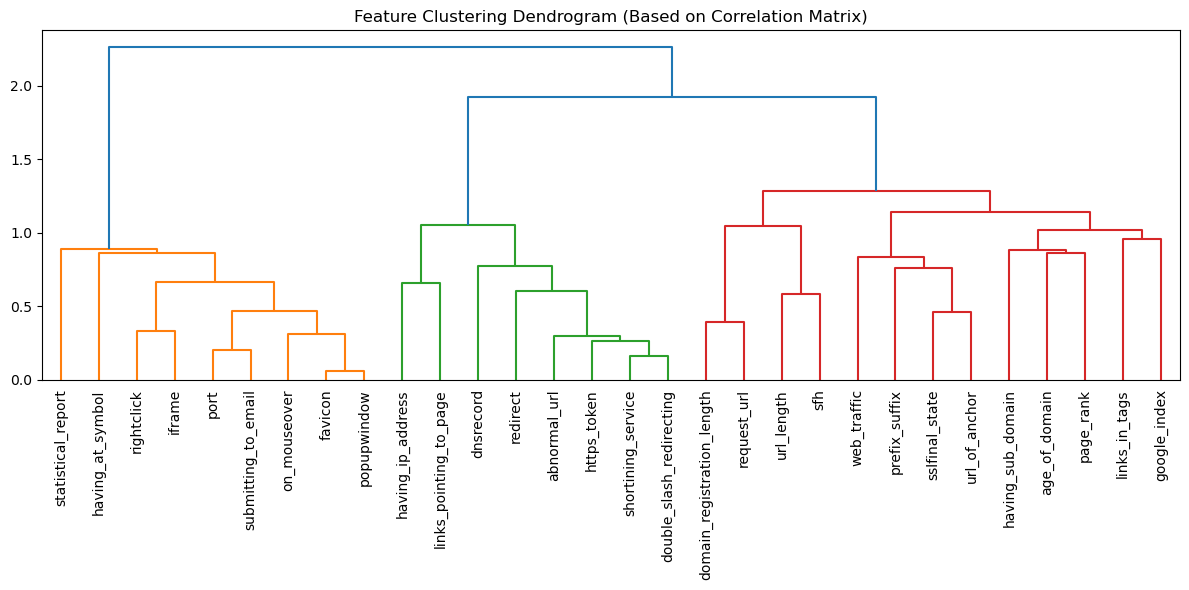

In [47]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

# --- Compute the correlation matrix (if not already computed) ---
corr = X_train.corr().abs()   # absolute correlations for cleaner clustering

# --- Convert correlation matrix to distance matrix ---
# distance = 1 - correlation
distance_matrix = 1 - corr

# Convert to condensed distance form (required by linkage)
dist_condensed = squareform(distance_matrix)

# --- Perform hierarchical clustering ---
linkage_matrix = linkage(dist_condensed, method="ward")

# --- Plot dendrogram ---
plt.figure(figsize=(12, 6))
dendrogram(
    linkage_matrix,
    labels=X_train.columns,
    leaf_rotation=90,
    leaf_font_size=10
)

plt.title("Feature Clustering Dendrogram (Based on Correlation Matrix)")
plt.tight_layout()
plt.show()






## Calculate the  Mutual Information Classification of the predictors

In [48]:
from sklearn.feature_selection import mutual_info_classif


# Calculate mutual information scores
mi_scores = mutual_info_classif(X_train, y_train, random_state=42)

# Create DataFrame with feature names and MI values
mi_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Mutual Information": mi_scores
})

# Sort by importance (descending)
mi_df = mi_df.sort_values(by="Mutual Information", ascending=False).reset_index(drop=True)

mi_df



,Feature,Mutual Information
0,sslfinal_state,0.345905
1,url_of_anchor,0.332494
2,prefix_suffix,0.092891
3,having_sub_domain,0.084340
4,web_traffic,0.074103
5,request_url,0.040270
6,domain_registration_length,0.029485
7,links_in_tags,0.029203
8,sfh,0.026861
9,submitting_to_email,0.017364


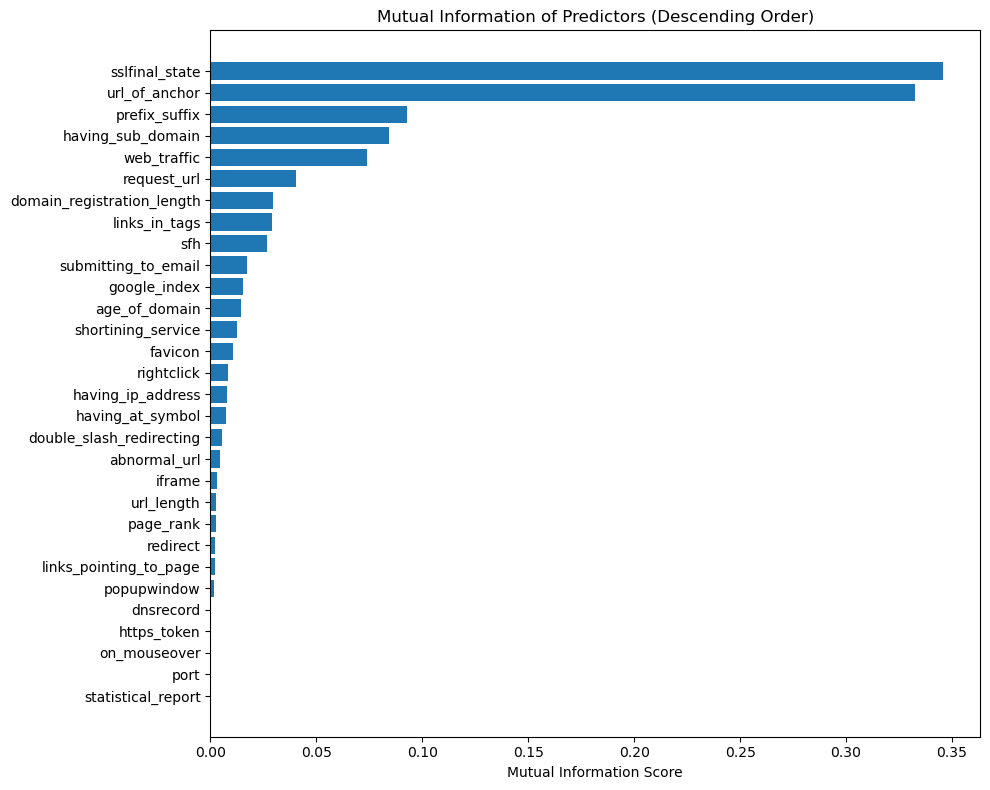

In [49]:

# Ensure MI DataFrame is sorted in descending order
mi_df_sorted = mi_df.sort_values(by="Mutual Information", ascending=True)  # ascending=True for horizontal barplot

plt.figure(figsize=(10, 8))
plt.barh(mi_df_sorted["Feature"], mi_df_sorted["Mutual Information"])
plt.xlabel("Mutual Information Score")
plt.title("Mutual Information of Predictors (Descending Order)")
plt.tight_layout()
plt.show()
